In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.parameter import Parameter

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.receptive_field_analysis.visualization as rfvis
import allensdk.brain_observatory.receptive_field_analysis.receptive_field as rf
from allensdk.brain_observatory.receptive_field_analysis.eventdetection import detect_events
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jothi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

In [3]:
data_set = boc.get_ophys_experiment_data(501474098)

In [4]:
N_neurons = data_set.number_of_cells
N_neurons

108

In [6]:
# Get the inputs; i.e. the stimulus presented in each frame
stimulus = "locally_sparse_noise"
stimulus_table = data_set.get_stimulus_table(stimulus)
X = data_set.get_stimulus_template(stimulus)[stimulus_table['frame'].values, :, :]
N_frames, H_px, W_px = X.shape

# Reshape it into a 2D array
X = X.reshape((N_frames, H_px * W_px))

In [7]:
# Construct the array of neuron responses for each frame
Y = np.zeros((N_frames, N_neurons), dtype=bool)
for n in range(N_neurons):
    Y[:,n] = detect_events(data_set, n, "locally_sparse_noise")

Text(0,0.5,'neuron')

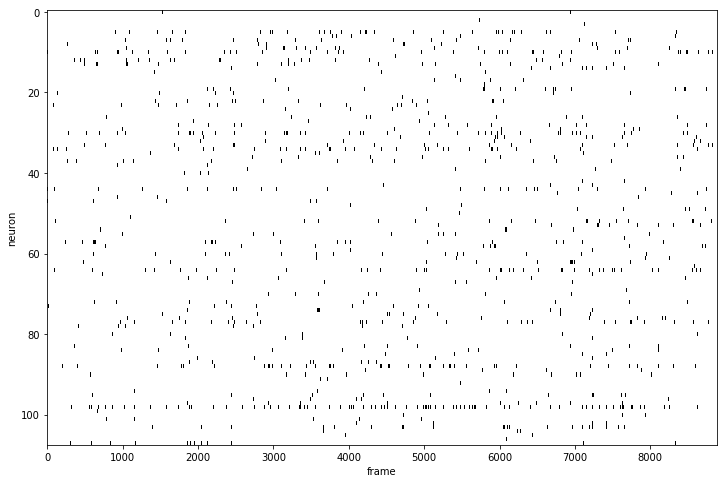

In [8]:
plt.figure(figsize=(12,8))
plt.imshow(Y.T, aspect="auto", cmap="Greys")
plt.xlabel("frame")
plt.ylabel("neuron")

In [9]:
# Sort the neurons by the total number of "events"
# Reverse it so that it's in decreasing order
perm = np.argsort(Y.sum(0))[::-1]

/Users/jothi/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


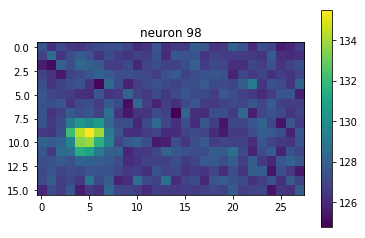

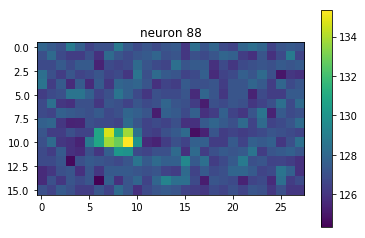

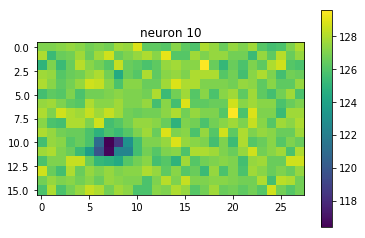

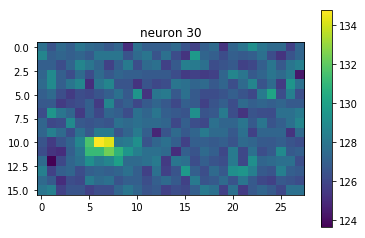

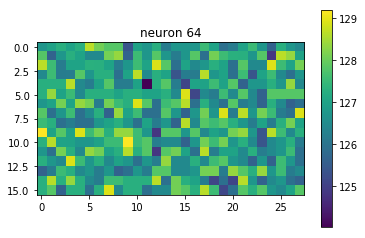

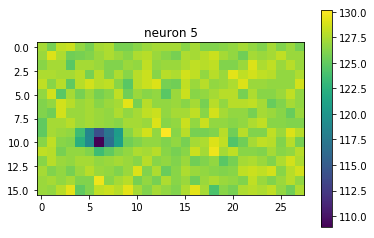

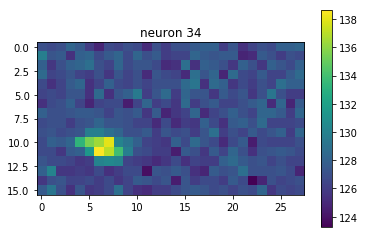

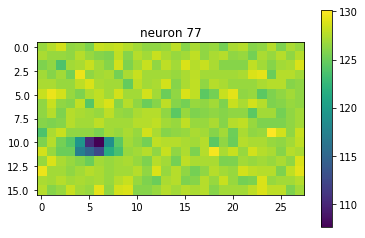

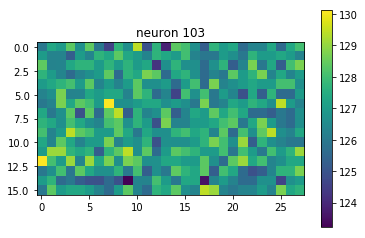

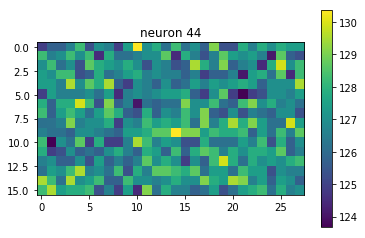

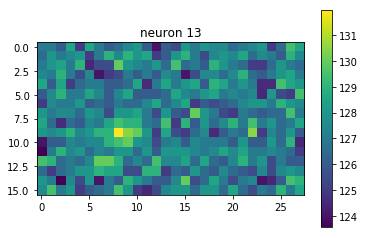

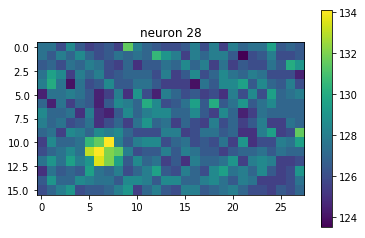

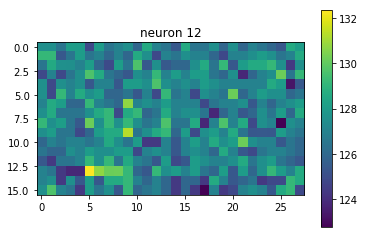

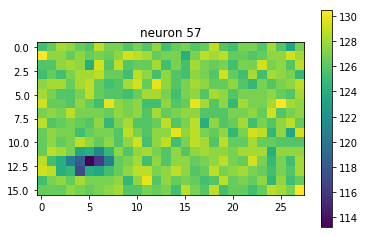

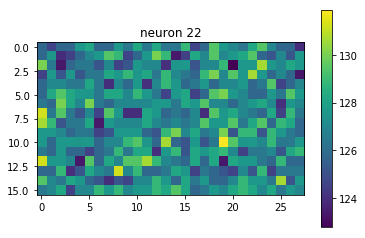

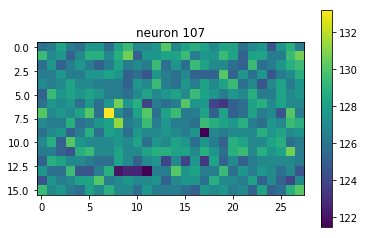

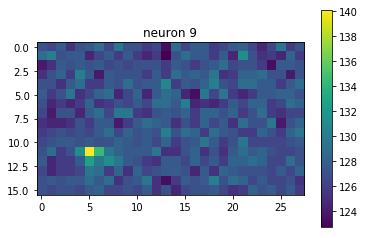

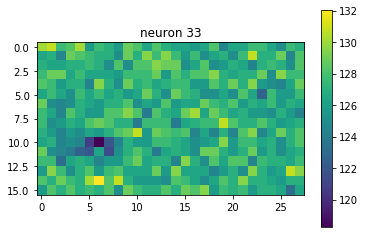

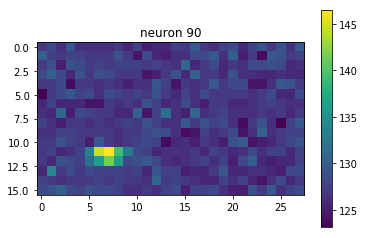

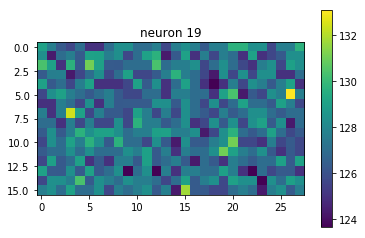

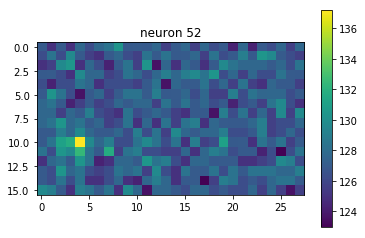

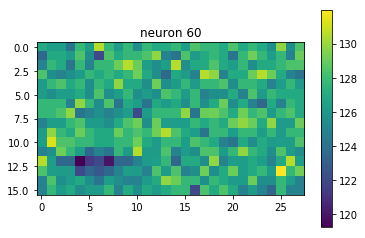

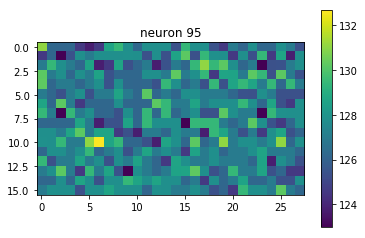

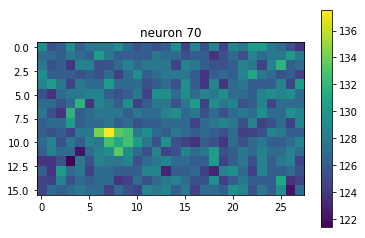

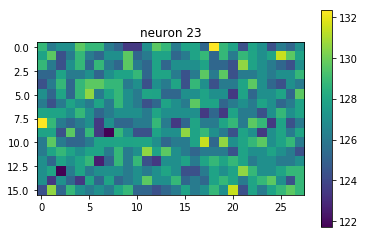

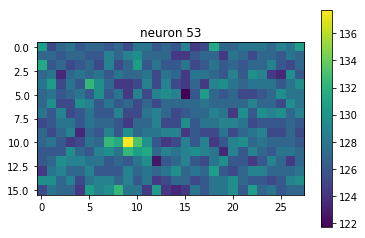

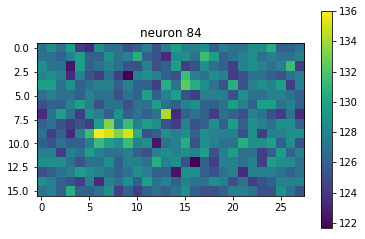

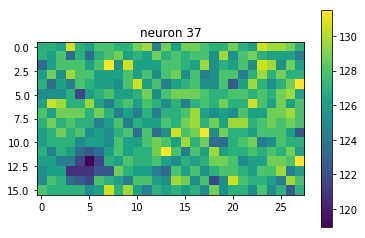

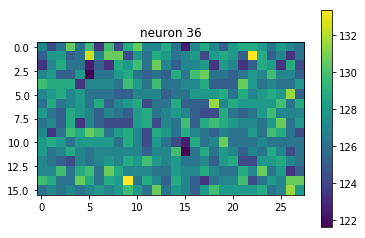

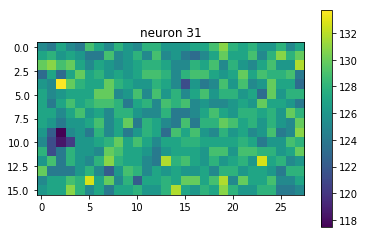

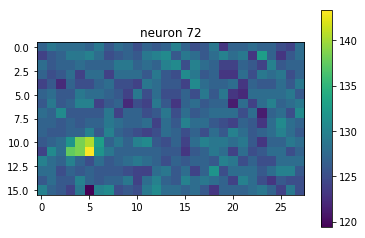

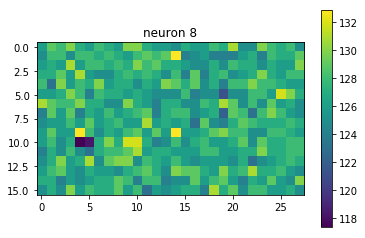

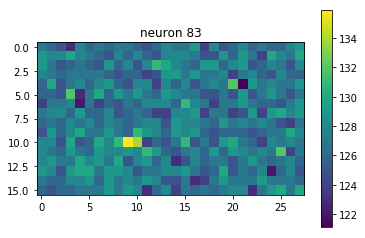

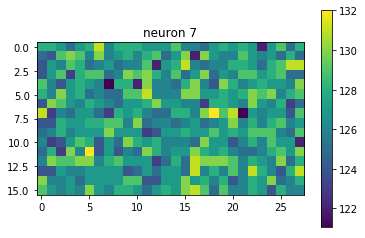

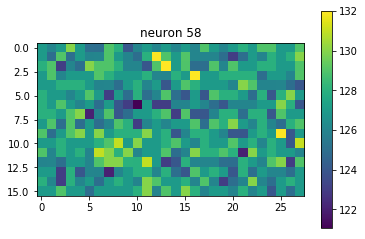

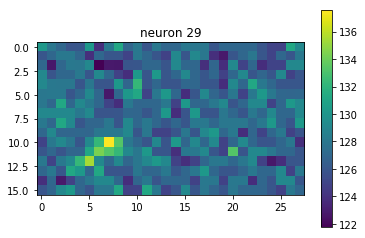

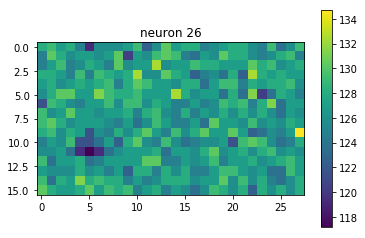

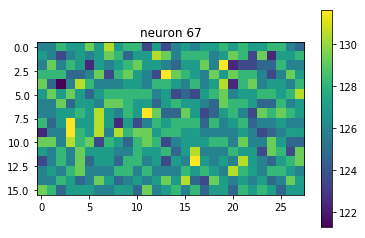

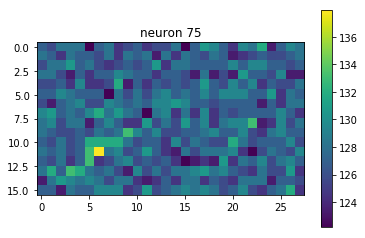

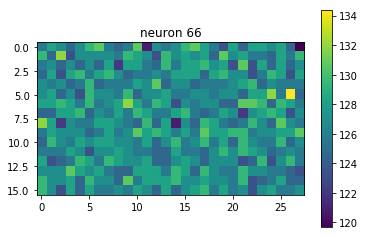

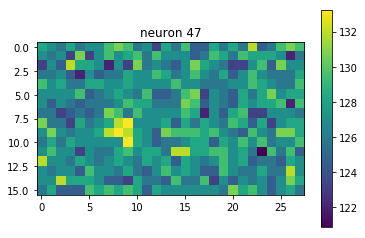

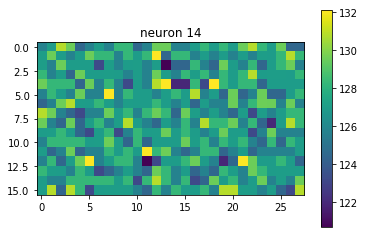

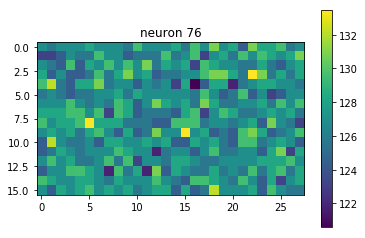

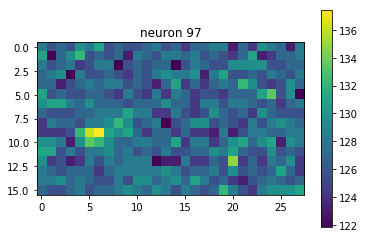

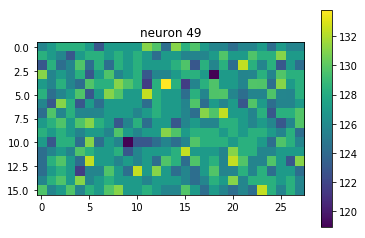

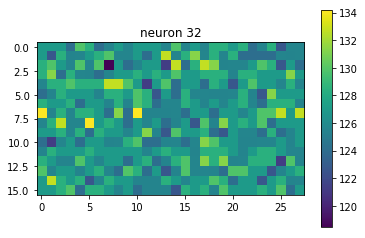

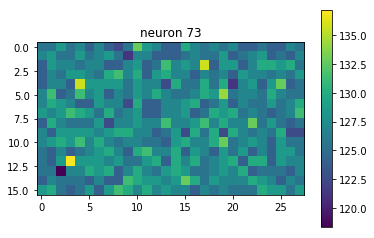

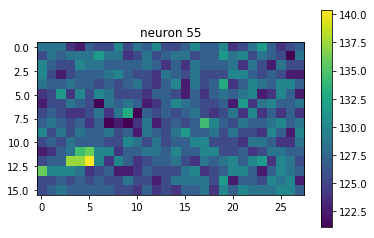

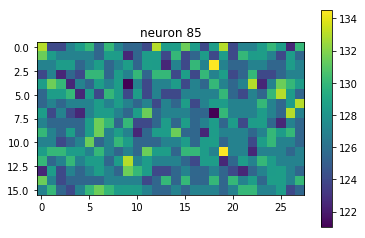

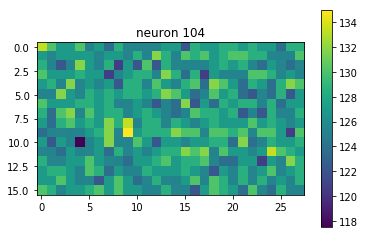

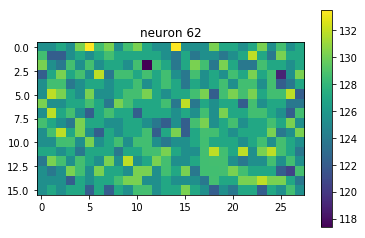

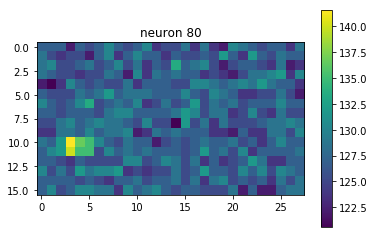

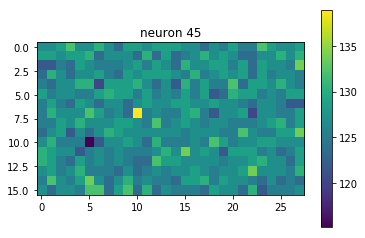

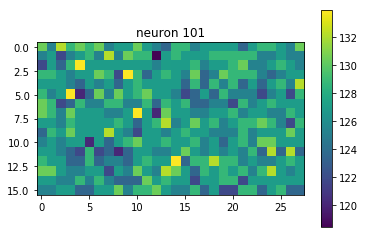

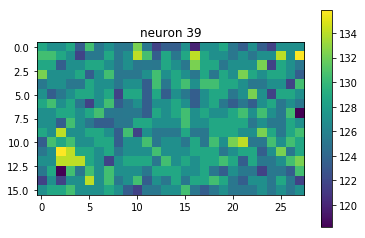

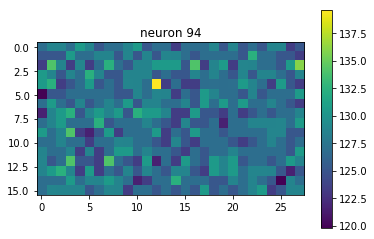

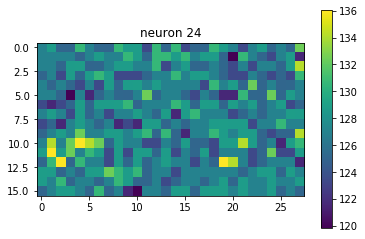

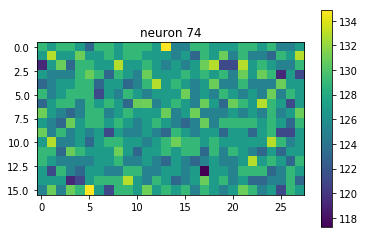

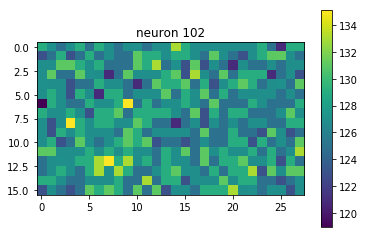

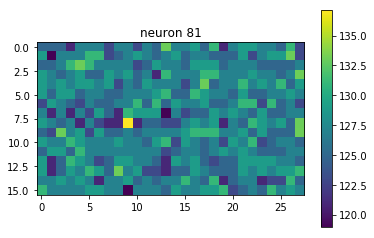

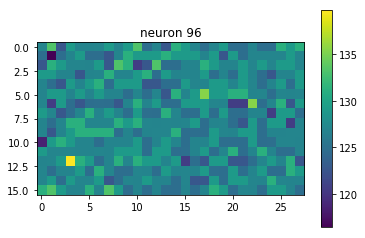

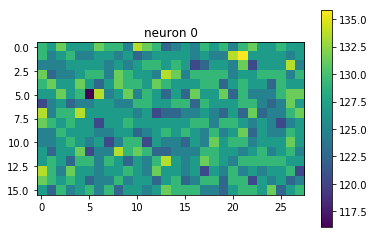

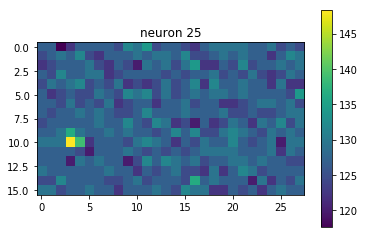

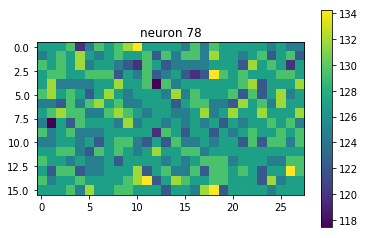

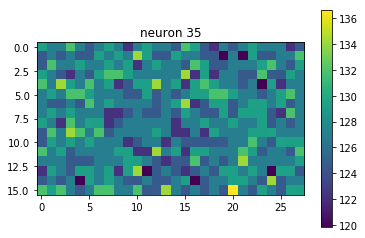

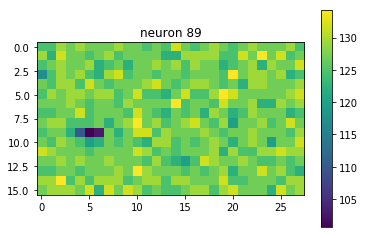

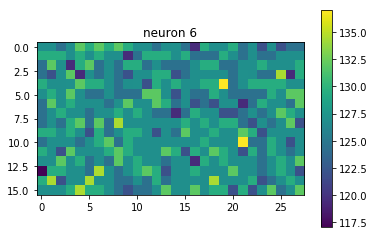

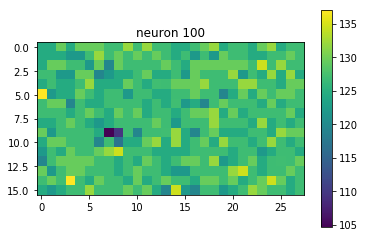

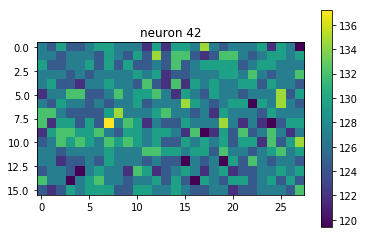

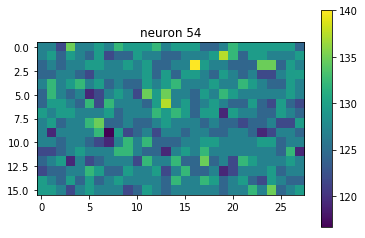

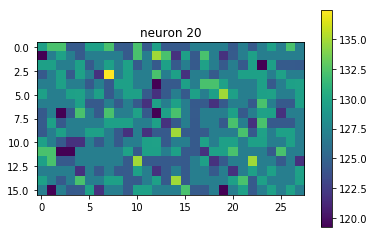

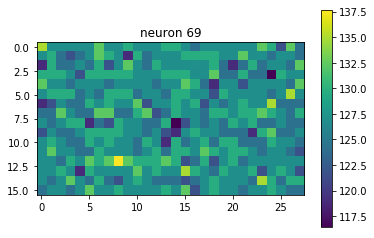

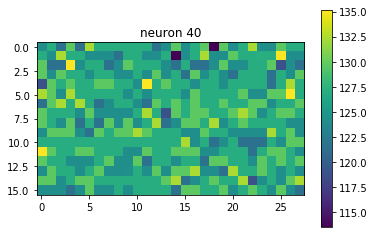

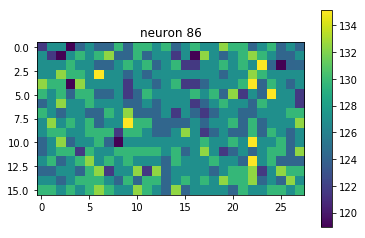

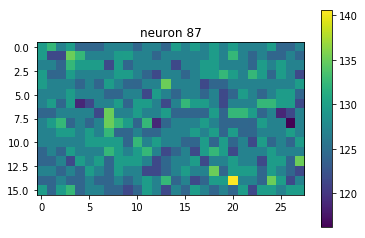

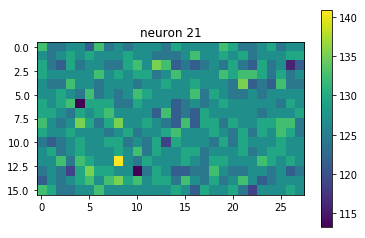

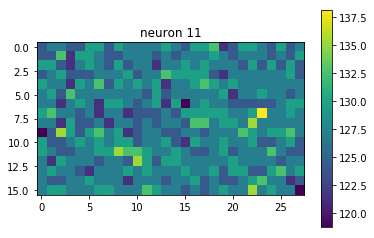

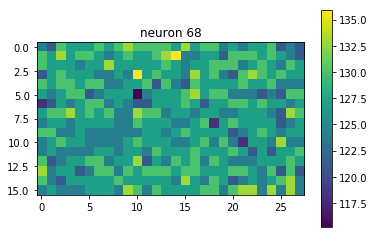

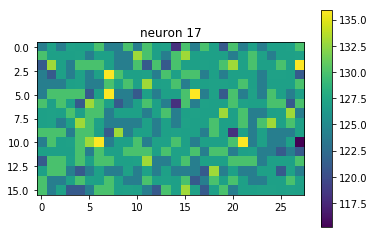

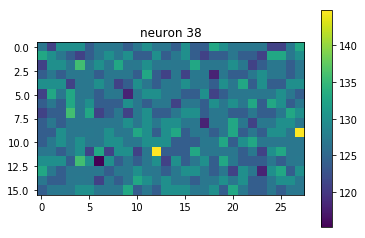

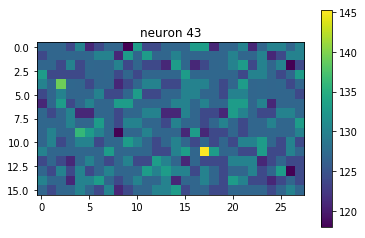

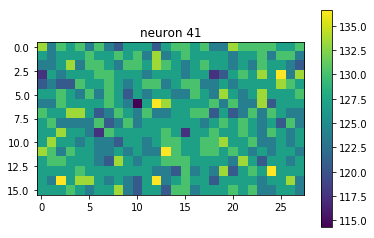

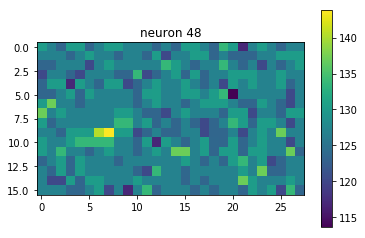

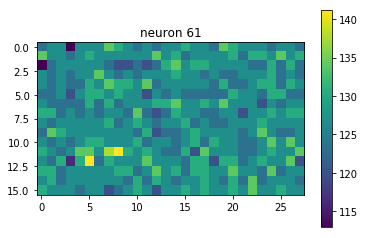

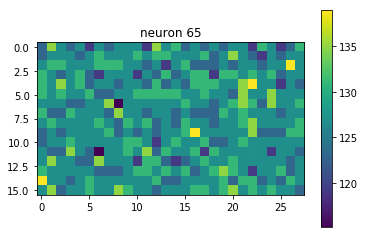

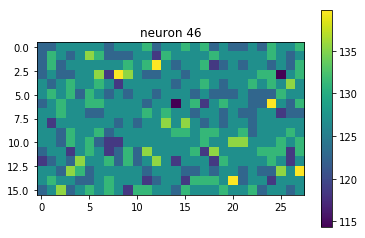

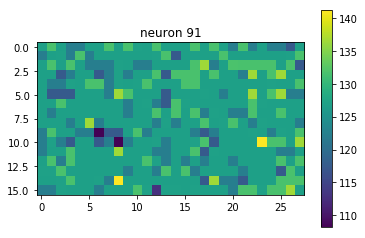

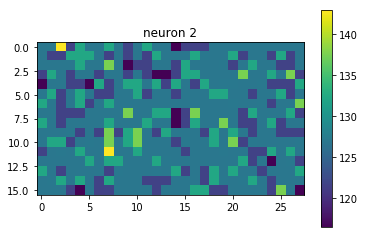

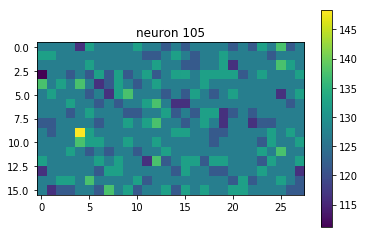

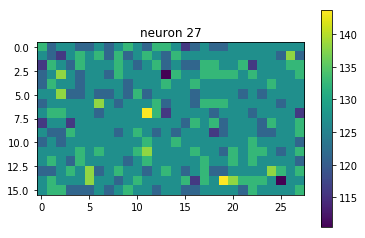

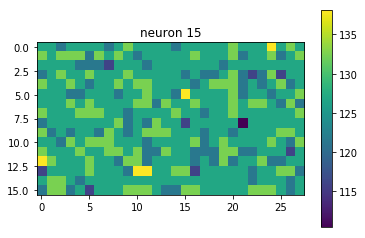

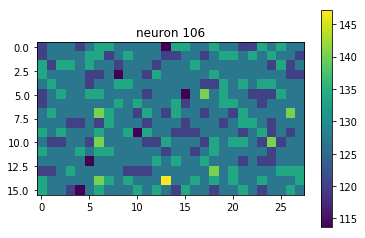

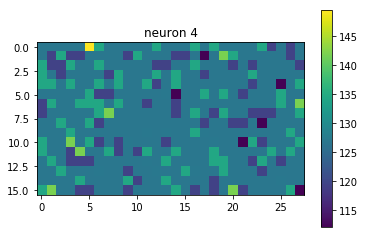

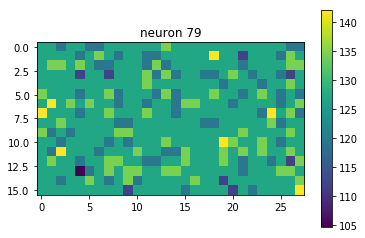

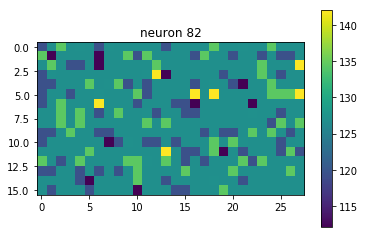

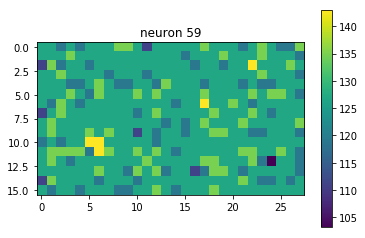

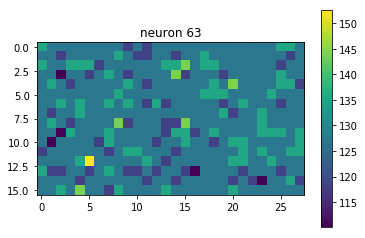

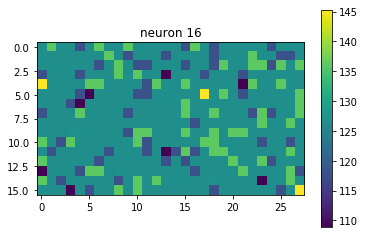

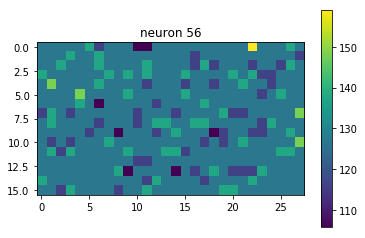

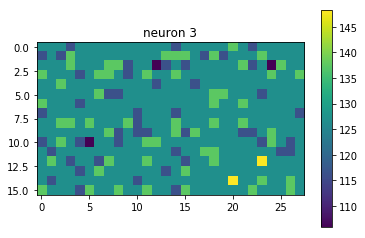

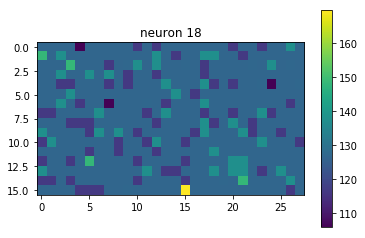

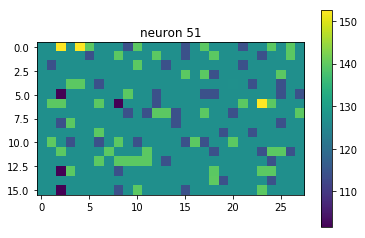

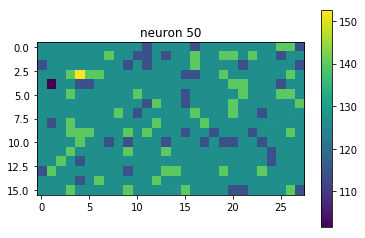

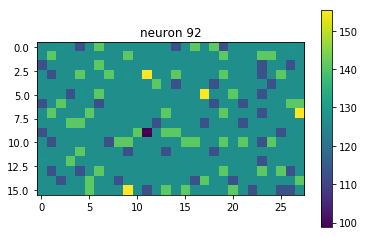

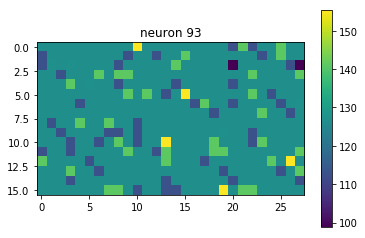

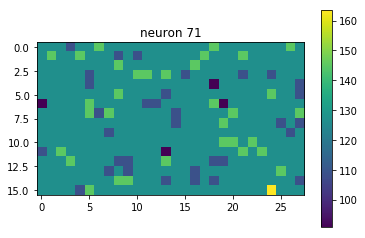

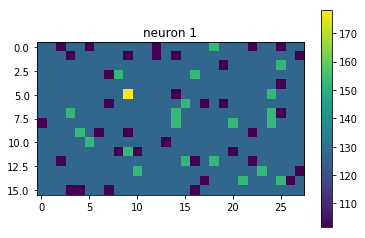

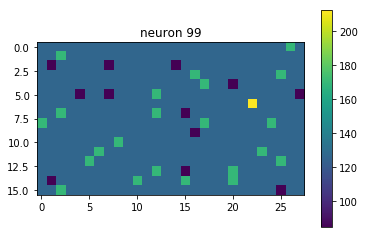

In [10]:
# Plot the average stimulus that gave rise to an event
for n in perm:
    # Extract the stimulus for frames in which the n-th neuron had an event
    sta = X[Y[:, n]].mean(0).reshape((H_px, W_px))
    
    # Plot the spike triggered average
    plt.figure()
    plt.imshow(sta)
    plt.title("neuron {}".format(n))
    plt.colorbar()

In [200]:
from sklearn import linear_model

class LogisticRegression(torch.nn.Module):
    def __init__(self, N_pixels, N_neurons):
        super(LogisticRegression, self).__init__()
        self.N_pixels = N_pixels
        self.N_neurons = N_neurons

        # Initialize the model weights: a single linear layer
        self.weights = torch.nn.Linear(N_pixels, N_neurons)

    def forward(self, X):
        return self.weights(X)
    
def logistic_loss(U, Y):
    # Convert U (output by the model) into log probabilities
    # log p(Y=1 | U) = log( 1 / (1 + exp(-U)) )
    #                = -log(1 + exp(-U))
    lp1 = -1 * torch.log(1 + torch.exp(-U))
    
    # log p(Y = 0 | U) = log ( 1 - 1 / (1 + exp(-U)) )
    #                  = log (1 / (1 + exp(U)))
    #                  = -log (1 + exp(U))
    lp0 = -1 * torch.log(1 + torch.exp(U))
    
    # Compute the Bernoulli loss
    # -log p(Y | U) = - log p(Y = 1 | U) * Y - log p(Y = 0 | U) * (1 - Y)
    #               = -lp1 * Y - lp0 * (1-Y)

    
    loss = -lp1 * Y - lp0 * (1-Y)
    
    # TODO: AVERAGE OVER SAMPLES
    
    avg = loss.mean(0)
    
    return avg

def logistic_(X, Y, i):
    Cs = [10, 1.0, 0.1, 0.01]
    scores = []
    

    for C in Cs:
        lr = linear_model.LogisticRegression(C=C, penalty='l1')
        C_mean = np.mean(cross_val_score(lr, X, Y[:,i], cv=5))
        scores.append(C_mean)
        
    best_C = np.argmax(scores)
    lr = linear_model.LogisticRegression(C=Cs[best_C], penalty='l1')
    lr.fit(X, Y[:,i])

    return lr

def logistic_with_neurons(X, Y, i):
    Cs = [10, 1.0, 0.1, 0.01]
    scores = []

    j = i + 1
    neurons = np.column_stack((Y[:,:i], Y[:,j:]))
    X_with_neurons = np.column_stack((X, neurons))
        
    for C in Cs:
        lr = linear_model.LogisticRegression(C=C, penalty='l1')
        C_mean = np.mean(cross_val_score(lr, X_with_neurons, Y[:,i], cv=5))
        scores.append(C_mean)
            
    best_C = np.argmax(scores)
    lr = linear_model.LogisticRegression(C=Cs[best_C], penalty='l1')
    lr.fit(X_with_neurons, Y[:,i])

    return lr

In [265]:
# Standardize the inputs and outputs
x = np.array(X, dtype=np.float64)
x -= x.mean()
x /= x.std()

6.2905284044715595

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [266]:
#save models for each neuron, run method once for each neuron, print something when each neuron finishes running
test = []

for i in range(10):
    lr = logistic_with_neurons(X_train, y_train, i)
    test.append(lr)
    print(i)


0


/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 m

1
2
3
4
5
6
7
8
9


In [195]:
#save models for each neuron, run method once for each neuron, print something when each neuron finishes running
logreg = []

for i in range(Y.shape[1]):
    lr = logistic_with_neurons(X_train, y_train, i)
    logreg.append(lr)
    print(i)


0


/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 m

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 m

71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 m

99
100
101
102
103
104
105
106
107


In [201]:
logreg_no_neurons = []

for i in range(Y.shape[1]):
    lr = logistic_(X_train, y_train, i)
    logreg_no_neurons.append(lr)
    print(i)

0


/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 m

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 4 m

71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 m

99
100
101
102
103
104
105
106
107


In [197]:
total = 0
for i in range(Y.shape[1]):
    j = i + 1
    neurons_train = np.column_stack((y_train[:,:i], y_train[:,j:]))
    X_neurons_train = np.column_stack((X_train, neurons_train))
    total= total + (logreg[i].score(X_neurons_train, y_train[:,i]))
total = total/N_neurons
total

0.987693231977986

In [199]:
total1 = 0
scores = np.zeros((Y.shape[1],5))
for i in range(Y.shape[1]):
    j = i + 1
    neurons_test = np.column_stack((y_test[:,:i], y_test[:,j:]))
    X_neurons_test = np.column_stack((X_test, neurons_test))
    total1= total1 + (logreg[i].score(X_neurons_test, y_test[:,i]))
total1 = total1/N_neurons
total1

0.9859989638222324

In [202]:
total2 = 0
scores_2 = np.zeros((Y.shape[1],5))
for i in range(Y.shape[1]):
    total2= total2 + (logreg_no_neurons[i].score(X_train, y_train[:,i]))
total2 = total2/N_neurons
total2

0.9876947884175992

In [203]:
total3 = 0
scores = np.zeros((Y.shape[1],5))
for i in range(Y.shape[1]):
    total3= total3 + (logreg_no_neurons[i].score(X_test, y_test[:,i]))
#     scores[i] = cross_val_score(logreg[i], X, Y[:,i], cv=5)
total3 = total3/N_neurons
total3

0.9859958047436724

In [204]:
score_table = [['         ','training','        test'],['w/ neurons',total, total1], ['w/oneurons', total2, total3]]

In [205]:
score_table

[['         ', 'training', '        test'],
 ['w/ neurons', 0.987693231977986, 0.9859989638222324],
 ['w/oneurons', 0.9876947884175992, 0.9859958047436724]]

In [233]:
sliced = logreg[5].coef_[:,448:448+i]
sliced

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

/Users/jothi/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


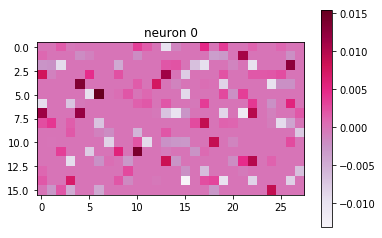

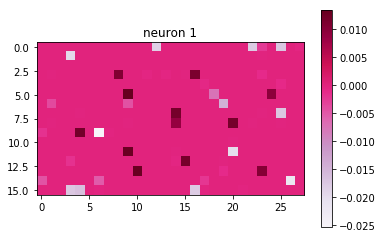

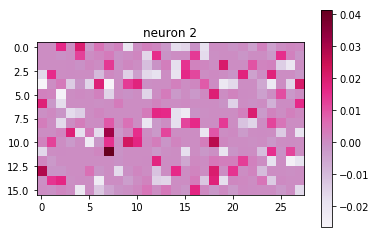

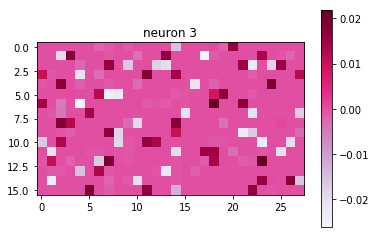

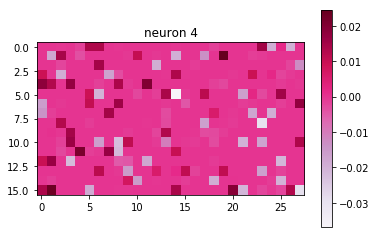

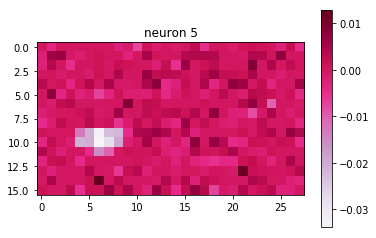

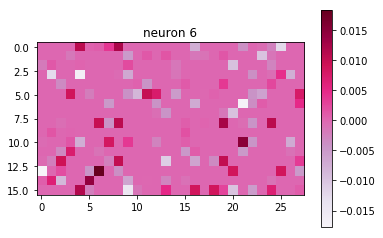

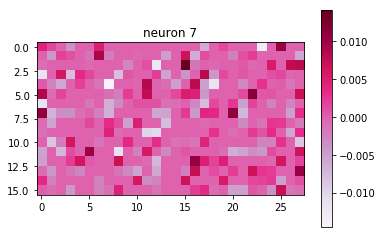

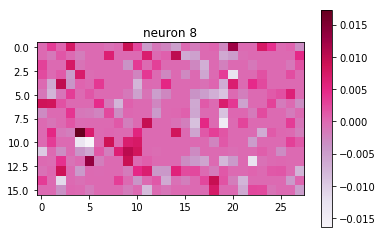

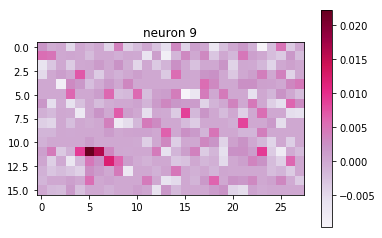

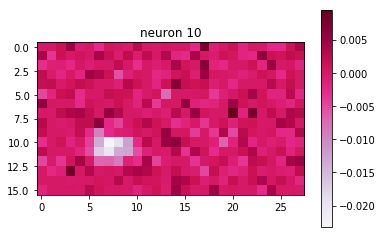

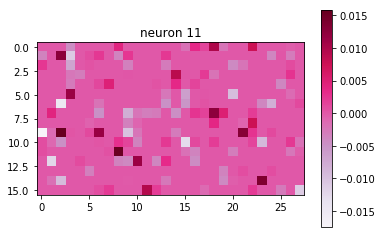

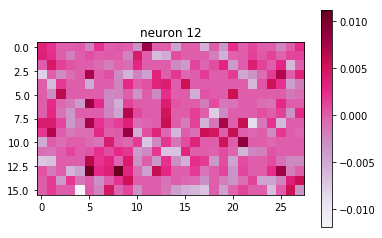

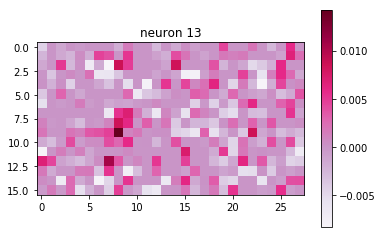

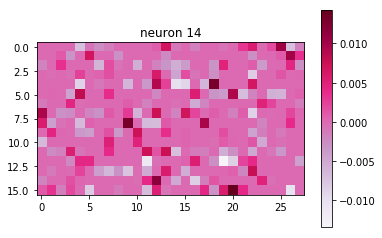

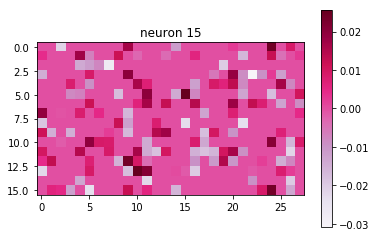

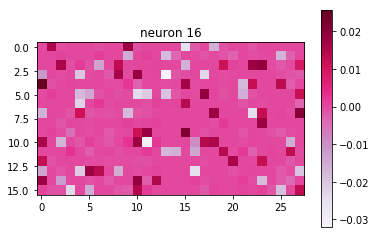

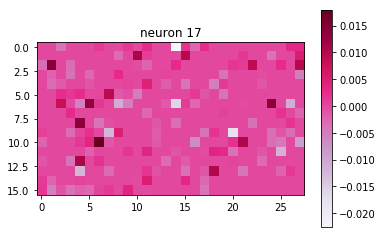

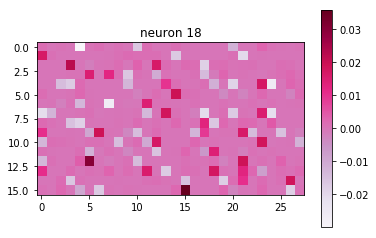

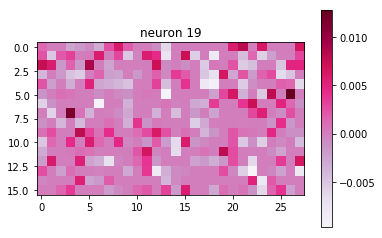

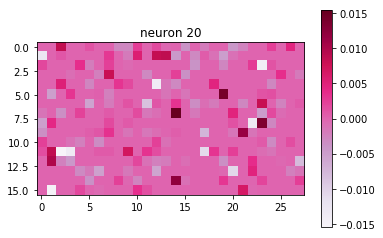

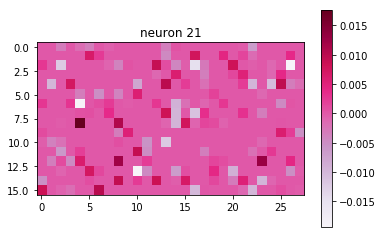

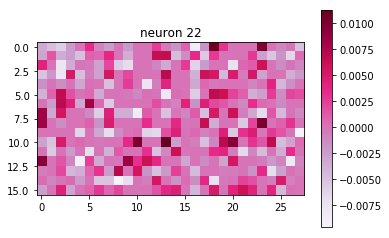

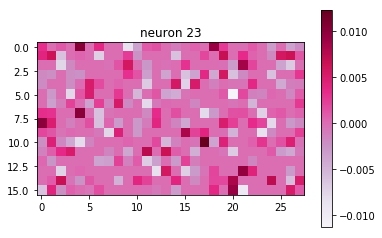

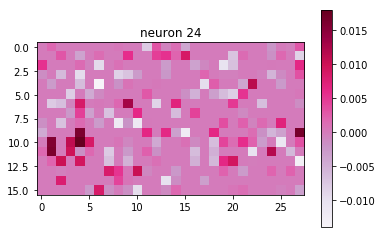

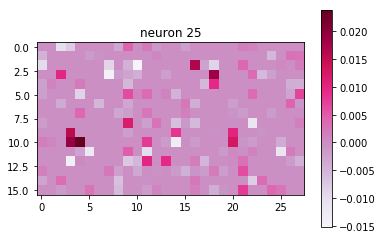

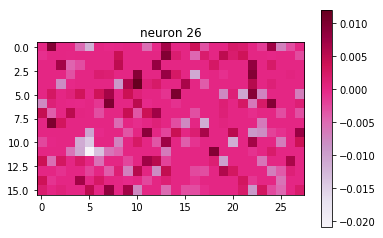

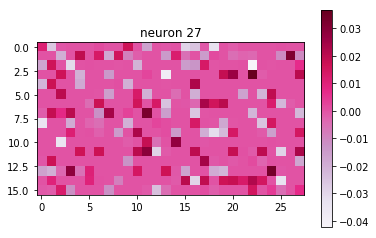

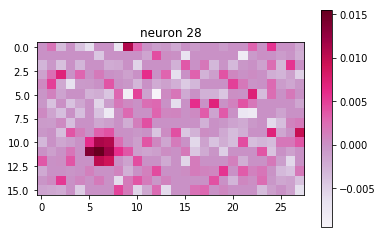

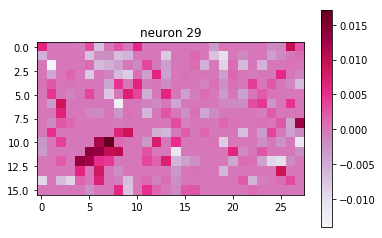

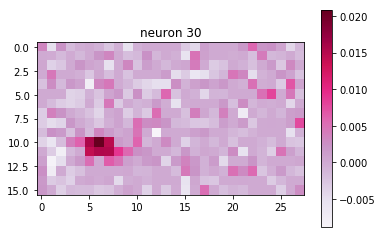

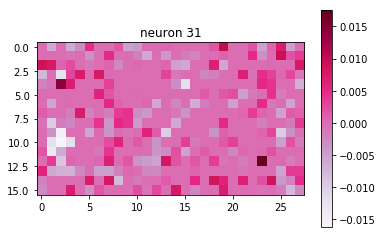

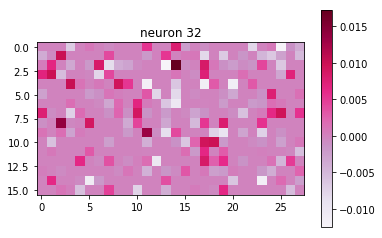

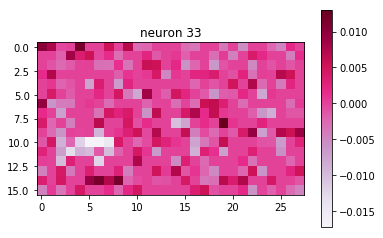

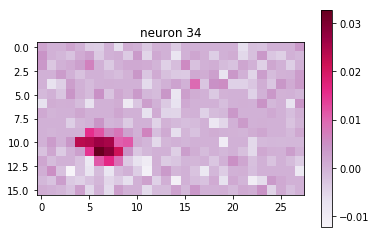

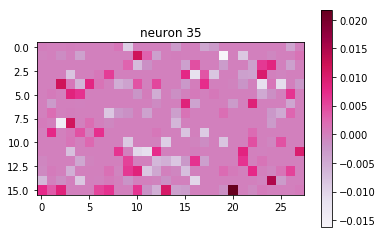

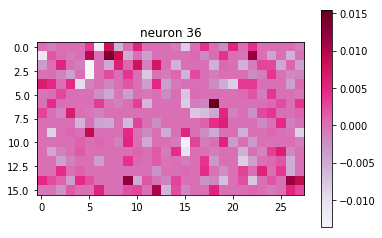

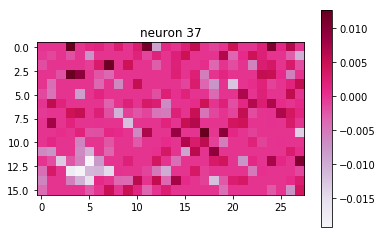

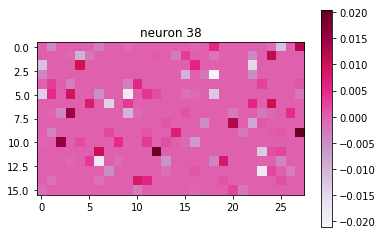

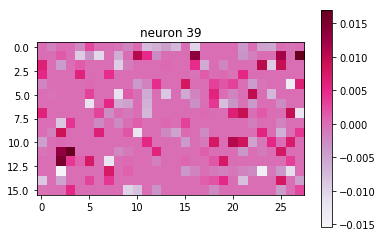

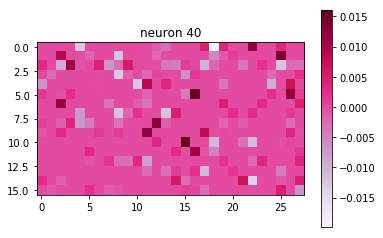

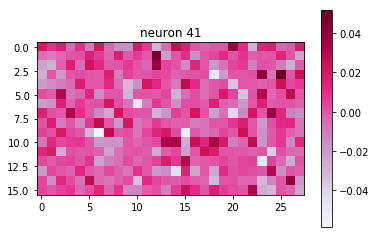

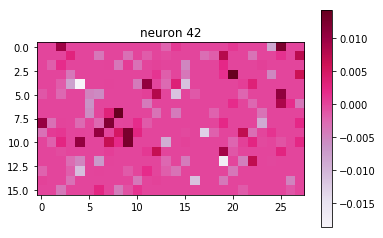

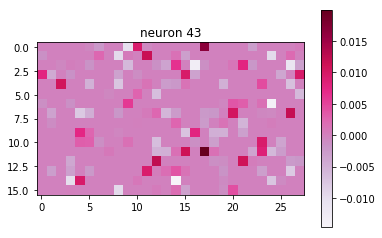

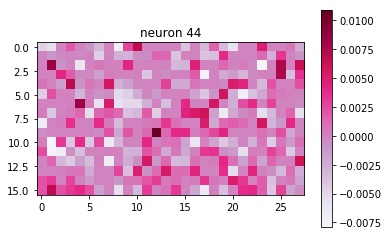

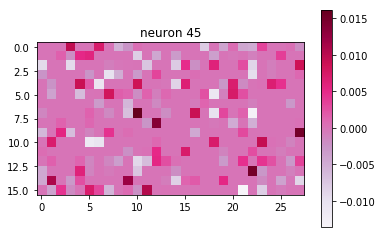

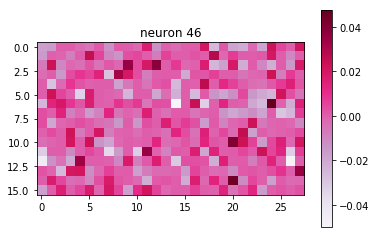

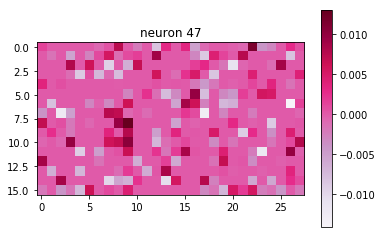

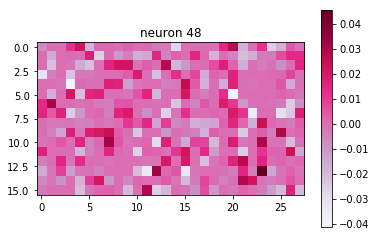

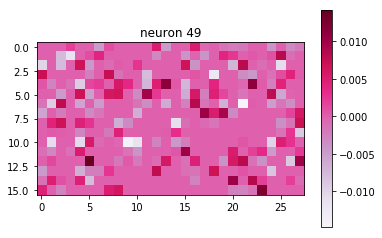

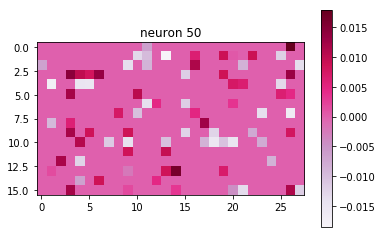

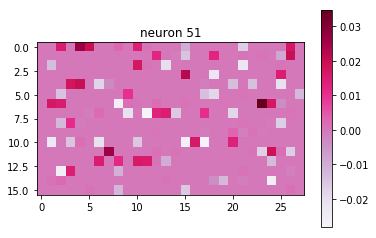

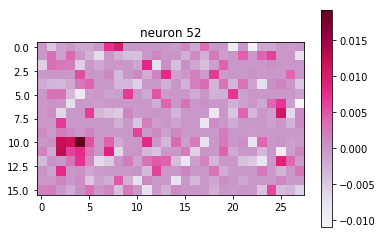

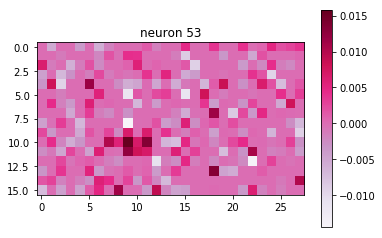

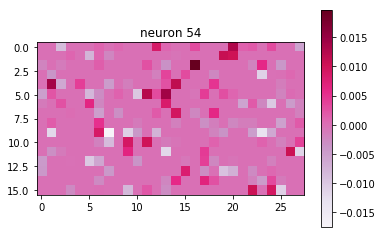

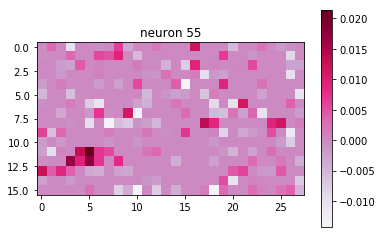

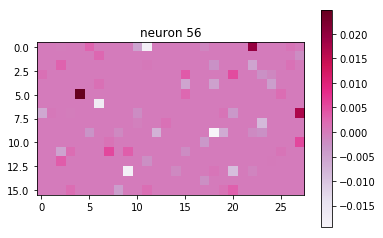

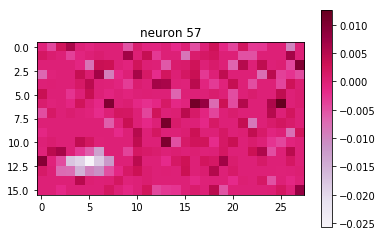

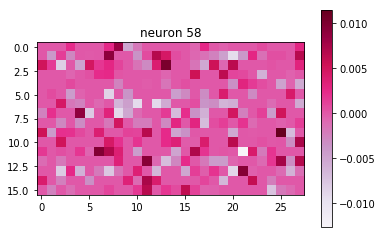

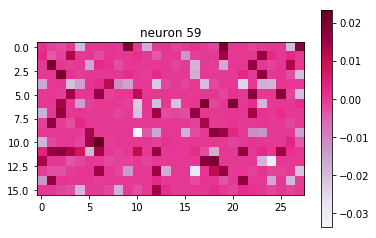

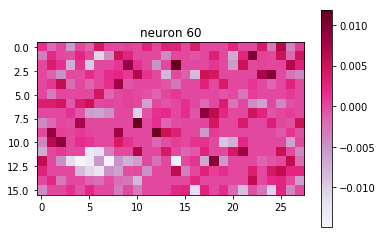

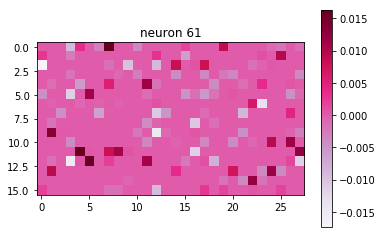

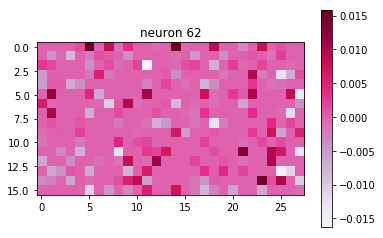

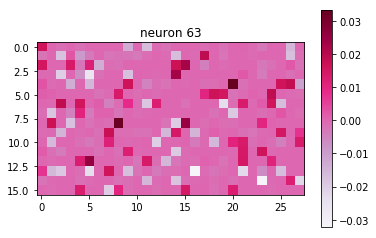

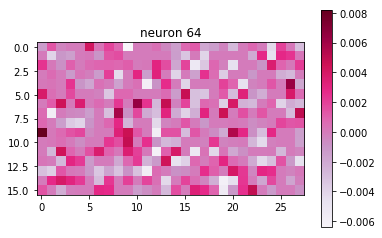

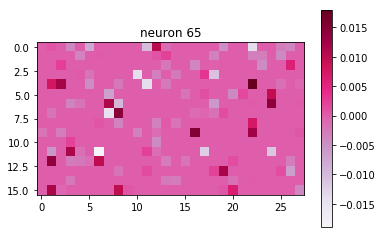

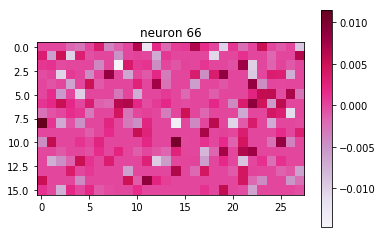

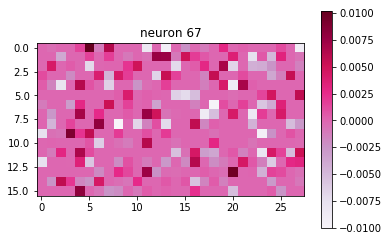

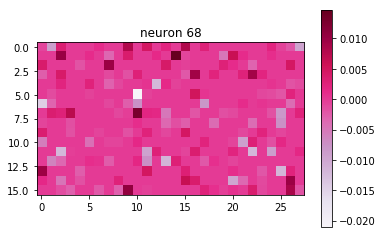

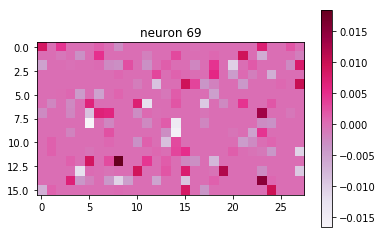

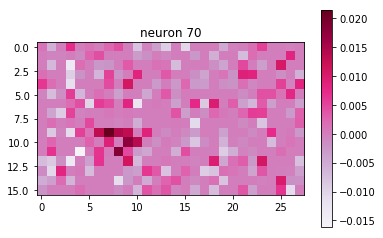

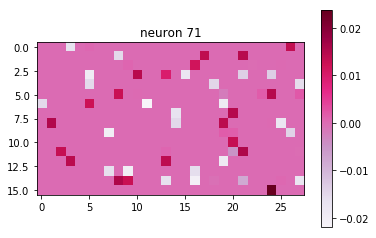

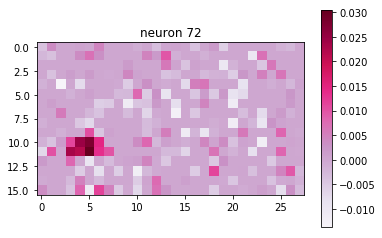

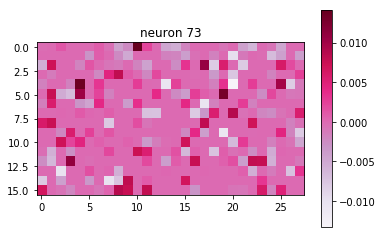

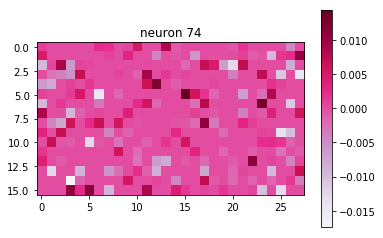

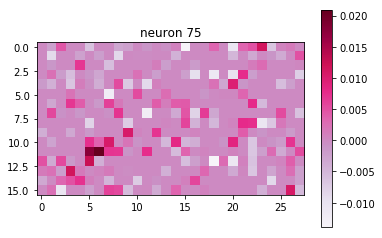

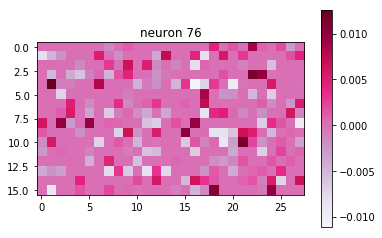

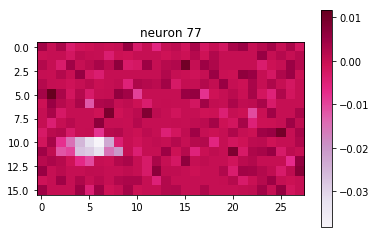

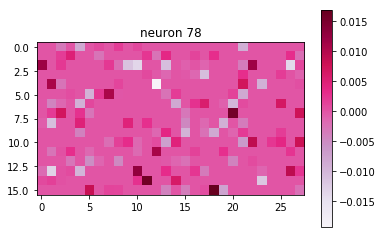

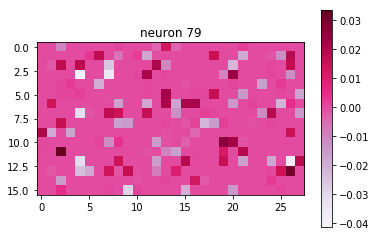

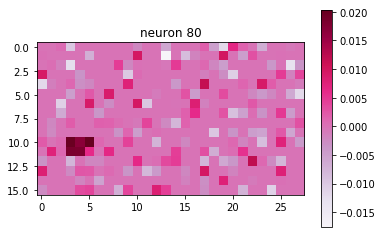

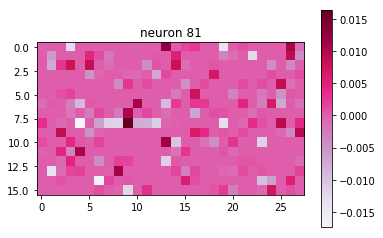

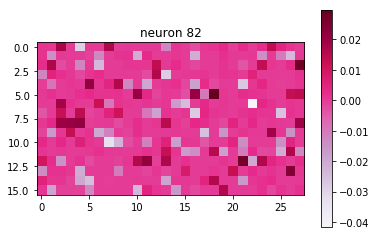

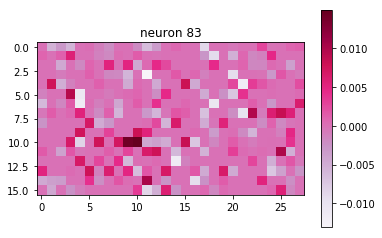

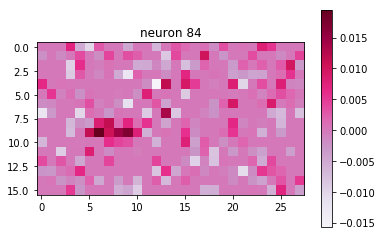

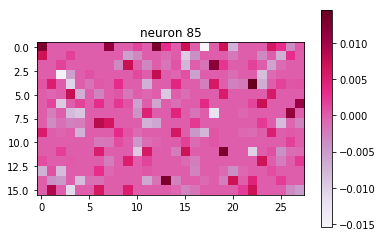

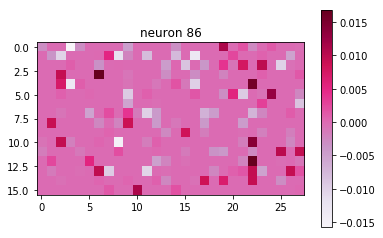

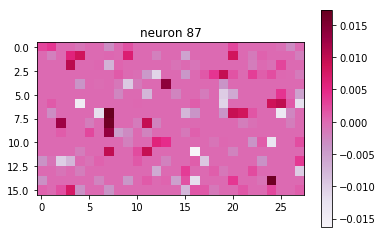

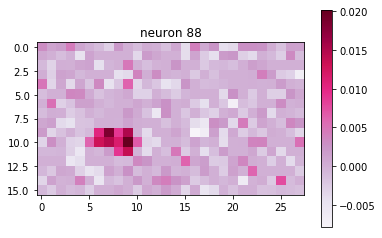

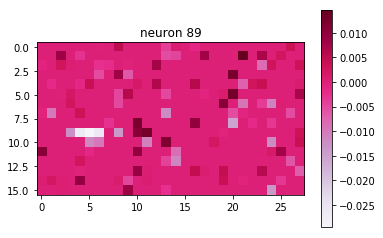

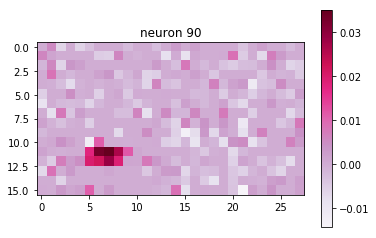

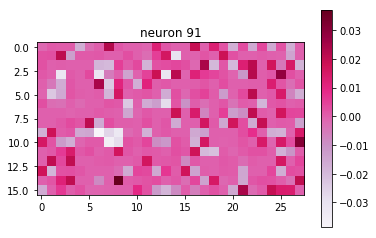

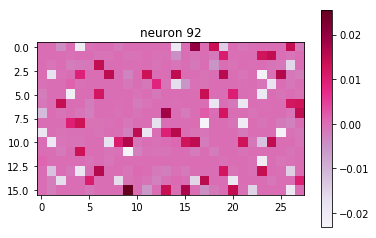

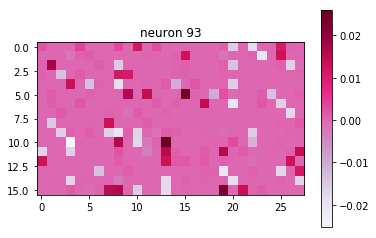

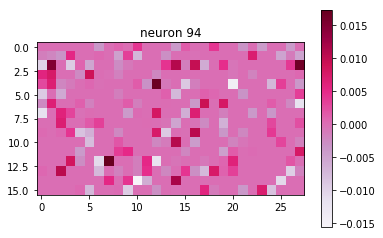

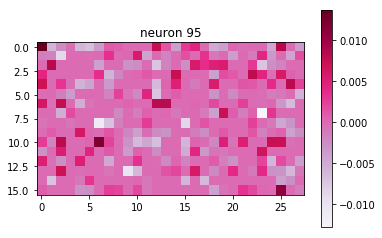

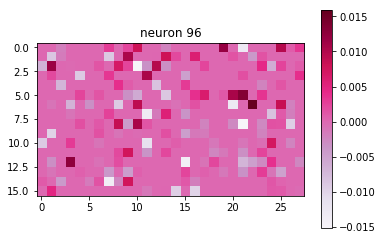

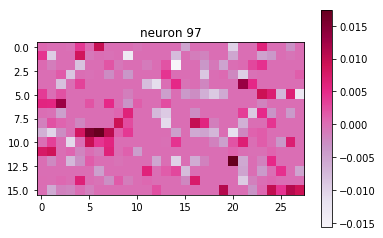

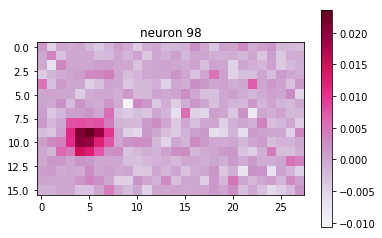

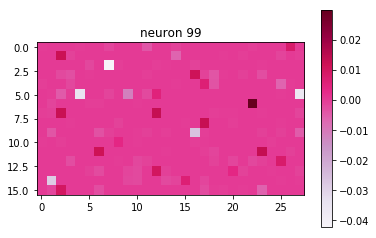

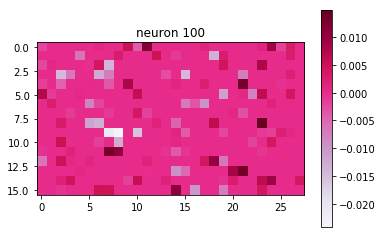

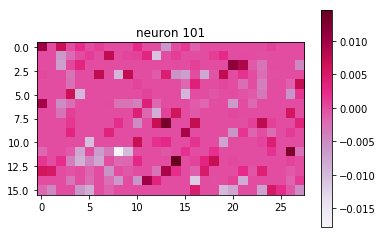

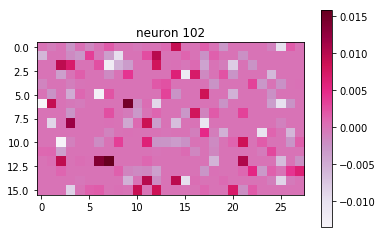

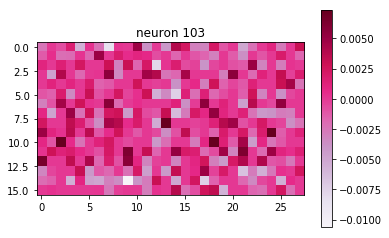

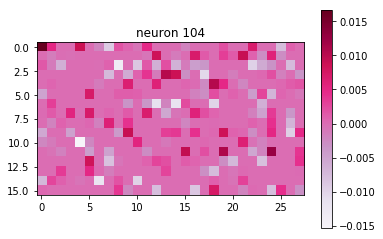

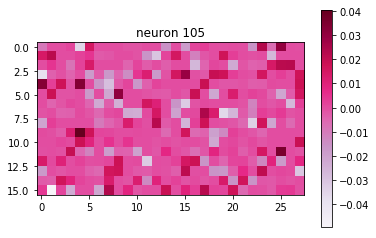

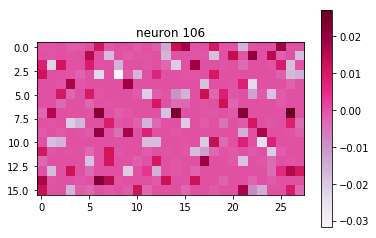

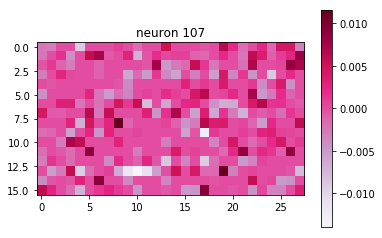

In [208]:
for i in range(y_train.shape[1]):
    plt.figure()
    plt.imshow(logreg[i].coef_[:,:448].reshape(16,28), cmap="PuRd")
    plt.colorbar()
    plt.title("neuron {}".format(i))


In [221]:
neuron_weights = np.zeros((N_neurons,N_neurons))

for i in range(N_neurons):
    w = np.column_stack((logreg[i].coef_[:,448:448+i], 0))
    weights = np.column_stack((w, logreg[i].coef_[:,448+i:]))
    neuron_weights[i] = weights

In [276]:
n_weights = np.zeros((10,108))

for i in range(10):
    w = np.column_stack((test[i].coef_[:,448:448+i], 0))
    weights = np.column_stack((w, test[i].coef_[:,448+i:]))
    n_weights[i] = weights

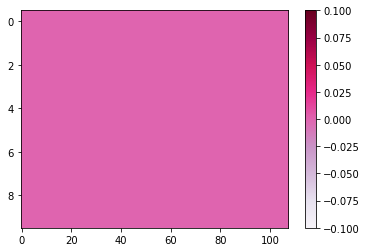

In [278]:
plt.imshow(n_weights, aspect='auto', cmap="PuRd")
plt.colorbar()

/Users/jothi/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


[2 0 2 2 2 2 2 6 2 2 2 0 0 2 2 0 4 2 7 2 0 0 0 2 2 2 2 4 2 2 2 2 2 0 2 7 2
 7 2 2 7 4 7 0 2 2 2 7 6 2 2 7 2 2 4 0 0 7 7 2 2 2 2 3 0 2 2 7 2 2 2 2 5 2
 0 2 2 2 4 0 7 0 2 2 1 0 2 2 0 6 0 2 0 2 4 2 7 0 7 3 3 0 2 2 2 0 0 2]


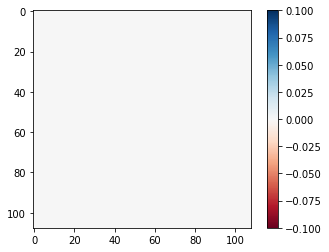

In [232]:
from sklearn.cluster import SpectralClustering
km = SpectralClustering(8)

W = abs(neuron_weights) > 1
km.fit(W)
print(km.labels_)

# print(bc.row_labels_)
# print(bc.column_labels_)
perm = np.argsort(km.labels_)
neuron_weights_perm = neuron_weights[np.ix_(perm, perm)]

plt.imshow(neuron_weights_perm, cmap="RdBu")

plt.colorbar()

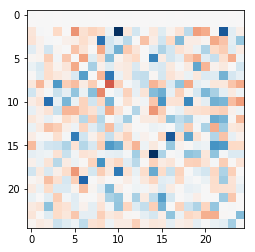

In [188]:
plt.imshow(neuron_weights_perm[-25:, -25:], cmap="RdBu", vmin=-3.5, vmax=3.5)

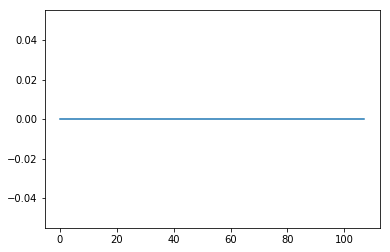

In [228]:
plt.plot(abs(np.linalg.eigvals(neuron_weights_perm)))

<BarContainer object of 108 artists>

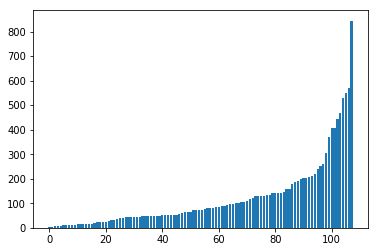

In [229]:
plt.bar(np.arange(Y.shape[1]), sorted(Y.sum(0)))